In [4]:
%pwd
%cd d:\\Murgi\\code\\memes2024\\meme-research-2024

d:\Murgi\code\memes2024\meme-research-2024


d:\Murgi\code\memes2024\meme-research-2024\phash\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
import pandas as pd
import numpy as np
from PIL import Image
import os, sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import time
import random
from tqdm.notebook import tqdm
from sklearn.linear_model import Lasso, LassoLars
from sklearn.preprocessing import LabelEncoder

In [6]:
meme_df = pd.read_parquet('./data/meme_entries.parquet')
template_df = pd.read_parquet('./data/meme_template_links.parquet')

Sample only 30 images from each template

In [7]:
# encode template name
labelencoder = LabelEncoder()
meme_df['template_id'] = labelencoder.fit_transform(meme_df['template_name'])
meme_df['template_id'] = meme_df['template_id'] + 1
sample_size = 30
sampled_meme_df = meme_df.groupby('template_name').apply(lambda x: x.sample(n=min(sample_size, len(x)),random_state=42))
sampled_meme_df = sampled_meme_df.reset_index(drop=True)
sampled_meme_df

,id,template_name,path,phash,template_id
0,0-days-without-Lenny-Simpsons_85,0-days-without-lenny-simpsons,D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...,07e5b23ee806f638,1
1,0-days-without-Lenny-Simpsons_10,0-days-without-lenny-simpsons,D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...,17e5b22ee806fe30,1
2,0-days-without-Lenny-Simpsons_51,0-days-without-lenny-simpsons,D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...,0fedb236e806fa30,1
3,0-days-without-Lenny-Simpsons_76,0-days-without-lenny-simpsons,D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...,07edb21ee806fa38,1
4,0-days-without-Lenny-Simpsons_29,0-days-without-lenny-simpsons,D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...,0fe1ba36e806fa38,1
...,...,...,...,...,...
34345,Zuckerberg_28,zuckerberg,D:/Memes2024/Zuckerberg/Zuckerberg_28.jpg,734c93a7266631cd,1145
34346,Zuckerberg_10,zuckerberg,D:/Memes2024/Zuckerberg/Zuckerberg_10.jpg,734889a727e331e5,1145
34347,Zuckerberg_39,zuckerberg,D:/Memes2024/Zuckerberg/Zuckerberg_39.jpg,7148c9a72de23d65,1145
34348,Zuckerberg_6,zuckerberg,D:/Memes2024/Zuckerberg/Zuckerberg_6.jpg,7148db7324c73372,1145


# Functions

These functions will make computations easier. They are inspired by the articles.

In [8]:
def delta(x,i,class_num):
    '''
    Function that selects the coefficients associated with the ith class
    Useful for SCI calculation
    m: number of samples
    - x: vector of coefficients, shape (m,)
    - i: class index
    - class_num: vector of training labels, shape (m,)
    '''
    n,m = len(x),len(class_num)
    
    if (n != m):
        print('Vectors of differents sizes')
        
    tmp = i*np.ones(n)-class_num

    for k in range(n):
        if tmp[k]==0:
            tmp[k]=1
        else:
            tmp[k]=0 
    
    return tmp*x


Vectorized version of the delta function:

In [9]:
def delta_vectorized(x, class_num):
    '''
    Function that selects the coefficients associated with the ith class
    Useful for SCI calculation
    m: number of samples
    - x: vector of coefficients, shape (m,)
    - class_num: vector of training labels, shape (m,)
    '''
    n, m = len(x), len(class_num)
    
    if (n != m):
        print('Vectors of different sizes')

    k = np.max(class_num)+1

    tmp = np.subtract(np.multiply(np.ones((n, k)),np.arange(k)),class_num[:, np.newaxis])
    tmp = np.where(tmp == 0, 1, 0)
    
    return (tmp * x[:, np.newaxis])

Test the vectorized delta:

In [10]:
import numpy as np

def test_delta(x,class_num):
    # number of classes
    k = np.max(class_num)+1

    # Original function
    result1 = None
    for i in range(0,k):
        temp = delta(x, i, class_num)
        if i == 0:
            result1 = np.array(temp)
        else:
            result1 = np.append(result1, temp)

    result1 = result1.reshape(k, len(x))

    # Vectorized function
    result2 = delta_vectorized(x, class_num).T # We transpose here but this is not necessary in the main algorithm because of the dot product afterwards

    # Compare the results
    print(result1)
    print(result2)
    assert np.array_equal(result1, result2), "Results are not equal"
    print("Test passed!")


# labels of the samples
class_num_1 = np.array([0, 1, 2, 3, 3, 4, 4, 5])
# coefficients of the samples
x_1 = np.array([6, 6, 6, 6, 6, 6, 6, 7])

test_delta(x_1, class_num_1)

class_num_2 = np.array([0, 1, 2, 3, 3, 4, 4])
x_2 = np.array([6, 6, 6, 6, 6, 6, 6])

test_delta(x_2, class_num_2)

[[6. 0. 0. 0. 0. 0. 0. 0.]
 [0. 6. 0. 0. 0. 0. 0. 0.]
 [0. 0. 6. 0. 0. 0. 0. 0.]
 [0. 0. 0. 6. 6. 0. 0. 0.]
 [0. 0. 0. 0. 0. 6. 6. 0.]
 [0. 0. 0. 0. 0. 0. 0. 7.]]
[[6 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0]
 [0 0 0 6 6 0 0 0]
 [0 0 0 0 0 6 6 0]
 [0 0 0 0 0 0 0 7]]
Test passed!
[[6. 0. 0. 0. 0. 0. 0.]
 [0. 6. 0. 0. 0. 0. 0.]
 [0. 0. 6. 0. 0. 0. 0.]
 [0. 0. 0. 6. 6. 0. 0.]
 [0. 0. 0. 0. 0. 6. 6.]]
[[6 0 0 0 0 0 0]
 [0 6 0 0 0 0 0]
 [0 0 6 0 0 0 0]
 [0 0 0 6 6 0 0]
 [0 0 0 0 0 6 6]]
Test passed!


In [11]:
def residual(y,A,x,class_x):
    '''
    Returns the residuals of the model for each class
    n: number of features, m: number of samples
    - y: the target vector, shape (n,)
    - A: training images, shape (n, m)
    - x: the coefficients, shape (m,)
    - class_x: the train labels, shape: (m,) type: list
    '''
    k = np.max(class_x)+1
    r = np.zeros(k)
    
    for i in range(0,k):
        r[i] = np.linalg.norm(y - np.dot(A,delta(x,i,class_x)))        
    return r


Vectorized version of the residual function:

In [12]:
def residual_vectorized(y, A, x, class_x):
    '''
    Returns the residuals of the model for each class
    n: number of features, m: number of samples
    - y: the target vector, shape (n,)
    - A: training images, shape (n, m)
    - x: the coefficients, shape (m,)
    - class_x: the train labels, shape: (m,) type: list
    '''
    # Generate the delta matrix for all classes
    delta_matrix = delta_vectorized(x, class_x)
    
    # Compute the predicted values for each class
    predictions = np.dot(A, delta_matrix)
    
    # Calculate the errors by subtracting y from each column of predictions
    # Note: Need to reshape y to broadcast correctly against predictions
    errors = predictions - y.reshape(-1, 1)
    
    # Calculate the norm of errors for each class to get the residuals
    r = np.linalg.norm(errors, axis=0)
    
    return r

Test the vectorized residual function:

In [13]:
def test_residual(y, A, x, class_x):
    # Original function
    result1 = residual(y, A, x, class_x)

    # Vectorized function
    result2 = residual_vectorized(y, A, x, class_x)

    # Compare the results
    print(result1)
    print(result2)
    assert np.array_equal(result1, result2), "Results are not equal"
    print("Test passed!")

# Test the function
y = np.array([1, 2, 3])
A = np.array([[1, 1], [1, 1], [1, 1]])
x = np.array([4, 5])
class_x = np.array([0, 1])

test_residual(y, A, x, class_x)

[3.74165739 5.38516481]
[3.74165739 5.38516481]
Test passed!


The SCI function implements the Sparsity Concentration Index (with $k$ number of classes and $\delta_{i}$ the indicator of i-th class)  :

$$SCI(x)=\frac{k*max_i  \frac{\|\delta_{i}(x)\|_{1}}{\|x\|_{1}}-1}{k-1}$$

It is used to filter out bad images.

In [14]:
def SCI(x,class_num):
    '''
    - class_num: classe of a training element.
    - x        : sparse coefficients
    '''
    
    k = len(set(class_num)) # Number of different classes
    
    return (k*(1/np.linalg.norm(x,ord=1))*np.max([np.linalg.norm(delta(x,i,class_num),ord=1) for i in range(k)]) - 1)/(k-1)
    

Then we stack the images into vectors and concatenate them.

In [15]:
def stack(X_train,X_test):
    X_toconcat_train = [np.reshape(e,(X_train[0].shape[0]*X_train[0].shape[1],1)) for e in X_train]
    X_toconcat_test = [np.reshape(e,(X_train[0].shape[0]*X_train[0].shape[1],1)) for e in X_test]
    
    Xtrain = np.concatenate(X_toconcat_train,axis=1) # Each column is now an image of the train set
    Xtest = np.concatenate(X_toconcat_test,axis=1) # Each column is now an image of the test set

    return Xtrain,Xtest

In [ ]:
def read_images(meme_df, target_size=(64,64), filter=Image.LANCZOS):
    '''
    Read the images from the meme_df dataframe and return the images and the labels
    - meme_df: dataframe containing the path to the images and the template_id
    - target_size: size of the output images (default is (128,128))
    - filter: filter to use for resizing (default is Image.LANCZOS)
    '''
    path_list = meme_df['path'].tolist()
    template_list = meme_df['template_id'].tolist()
    X,y = [], []
    for (path, template) in tqdm(zip(path_list, template_list), total= len(path_list)):
        try:
            im = Image.open(path) 
            im = im.convert("L")
            # resize to given size (if given) and check that it's the good size
            im = im.resize(target_size, resample=filter)
            X.append(np.asarray(im, dtype=np.uint8))
            y.append(template)
        except IOError:
            pass
        except:
            print("Unexpected error:", sys.exc_info()[0])
            raise
    print("Images uploaded !")
    return np.array(X), np.array(y)

def read_image(path, target_size=(64,64), filter=Image.NEAREST):
    im = Image.open(path) 
    im = im.convert("L")
    # resize to given size (if given) and check that it's the good size
    im = im.resize(target_size, resample=filter)
    return np.asarray(im, dtype=np.uint8)

Load the data if already read, else read the data:

In [20]:
import pickle as pkl

save_path_X = "./data/X_original_64x64_sampled_30.pkl"
save_path_y = "./data/y_original_64x64_sampled_30.pkl"
load_df = sampled_meme_df

if os.path.exists(save_path_X):
    print("Load")
    X_original = pkl.load(open(save_path_X, 'rb'))
    y_original = pkl.load(open(save_path_y, 'rb'))

else:
    # X_original, y_original = read_images(load_df, filter=Image.NEAREST)
    with open(save_path_X, 'wb') as f:
        pkl.dump(X_original, f)

    with open(save_path_y, 'wb') as f:
        pkl.dump(y_original, f)

Load


# Whole Algorithm Commented (we will use only one function instead of pasting as many times as there are test sets)


Here we implement the algorithm 1 of the paper (relaxed version)
	
- Input : a matrix of training samples $A=\lbrack A_{1},A_{2},...,A_{k} \rbrack \in \mathbb{R}^{m \times n}$ for k classes and a test sample $y \in \mathbb{R}^{m}$
- Normalize the columns of A to have unit $L^{2}$ norm
- Solve the $L^{1}$ minimization problem : $\hat{x_{1}}= argmin \|x\|_{1}$   sc  $\|Ax-y\|_{2} \leq \epsilon$		
- Compute the residuals
	$ \mbox{ for all } i=1,...k, r_{i}(y)=\|y-A\delta_{i}(\hat{x_{1}})\|_{2}$
	
- $\mathcal{C}_{y}=argmin_{i} r_{i}(y)$
	

## Example from original notebook

Test_pic varies, it depends what the test set is (sunglasses, scarves, ...)

In [ ]:
test_pic = 0

In [ ]:
# clf = Lasso(alpha=4)

# y = Xtest[:,test_pic]

# clf.fit(Xtrain,y)
# x = clf.coef_

** Results **

In [ ]:
pred_class = np.argmin(residual(Xtest[:,test_pic],Xtrain,x,ytrain))

In [ ]:
print("Real class: ", ytest[test_pic])
print("Predicted class: ", pred_class)
print("SCI : ", SCI(x,ytrain))

Real class:  0
Predicted class:  0
SCI :  1.0


In [ ]:
class SparseMatchingClassifier:
    def __init__(self, alpha=4):
        self.alpha = alpha
        self.clf = Lasso(alpha=self.alpha)
    
    def fit_transform(self,X_train,y, y_train):
        self.clf.fit(X_train,y)
        self.y_train = y_train
        self.x = self.clf.coef_

        pred_class = np.argmin(residual(y,X_train,self.x,y_train))

        return pred_class

    def SCI(self):
        return SCI(self.x,self.y_train)

We see that the solution is really really sparse, that's work !

### Residuals

Text(0.5,0,'Class')

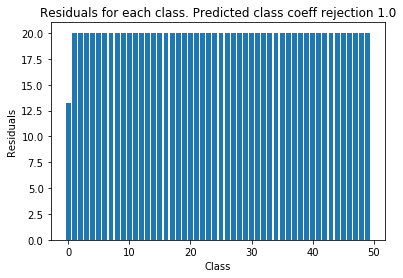

In [ ]:
plt.figure()
plt.clf()
plt.bar(range(50),residual(Xtest[:,test_pic],Xtrain,x,ytrain))
plt.title('Residuals for each class. Predicted class coeff rejection ' + str(np.round(SCI(x,ytrain),2)))
plt.ylabel('Residuals')
plt.xlabel('Class')

## Example 2.

Train test split

In [21]:
from sklearn.model_selection import train_test_split

print(np.unique(y_original))
X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.2, random_state=42, stratify=y_original)

[   1    2    3 ... 1143 1144 1145]


In [22]:
X_original.shape

(34350, 64, 64)

Normalize features

In [23]:
from sklearn.preprocessing import StandardScaler

X_train, X_test = stack(X_train,X_test)
print(X_train.shape)
ss = StandardScaler()
ss.fit(X_train.T) # We need to transpose the matrix because the StandardScaler expects the samples to be the rows
X_train = ss.transform(X_train.T).T
X_test = ss.transform(X_test.T).T
print(X_train.shape)
print(X_test.shape)
print(ss.n_features_in_)

(4096, 27480)
(4096, 27480)
(4096, 6870)
4096


In [24]:
X_train.shape, X_test.shape, X_original.shape

((4096, 27480), (4096, 6870), (34350, 64, 64))

In [25]:
import datetime
max_idx = X_test.shape[1]

# get 10 random indexes
# random_idx = random.sample(range(0, max_idx), 10)
random_idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for i in random_idx:
    example_y = X_test[:,i]

    clf = LassoLars(alpha=0.5)
    clf.fit(X_train,example_y)
    x = clf.coef_
    y_pred = np.argmin(residual(example_y,X_train,x,y_train))
    print(y_pred, y_test[i])


0 800


KeyboardInterrupt: 

Now test the whole algorithm with both original and vectorized implementation <br>
(The only line of difference is the one where we compute the residuals)


In [26]:
y = np.array([1, 2, 3])
A = np.array([[1, 2], [3, 4], [5, 6]])
class_x = np.array([0, 1])

def test_algorithm(A, y, class_x, alpha=0.35, max_iter=1000):
    # Original version
    clf = LassoLars(alpha=alpha, max_iter=max_iter)
    clf.fit(A,y)
    x = clf.coef_
    r = residual(y,A,x,class_x)
    # print(r)
    pred1 = np.argmin(r)
    print("Original Prediction:",pred1)

    # Vectorized version
    clf_2 = LassoLars(alpha=alpha, max_iter=max_iter)
    clf_2.fit(A,y)
    x_2 = clf_2.coef_
    r_2 = residual_vectorized(y,A,x_2,class_x)
    # print(r_2)
    pred2 = np.argmin(r_2)
    print("Vectorized Prediction:",pred2)
    try:
        assert np.array_equal(r, r_2), "Results are not equal"
    except AssertionError as e:
        print(e)
        print("r shape:", r.shape, "r_2 shape:", r_2.shape)
        # print("r:", r)
        # print("r_2:", r_2)
    try:
        assert pred1 == pred2, "Predictions are not equal"
    except AssertionError as e:
        print(e)
        print("pred1:", pred1, "pred2:", pred2)
    print("Test passed!")

test_algorithm(A, y, class_x)

Original Prediction: 0
Vectorized Prediction: 0
Test passed!


Let's test this on the real data!

In [27]:
xtrain = X_train[:,:1000]
ytrain = y_train[:1000]
xtest = X_test[:,:10]
ytest = y_test[:10]

for i in range(xtest.shape[1]):
    y = xtest[:,i]
    test_algorithm(xtrain, y, ytrain)

Original Prediction: 0
Vectorized Prediction: 0
Results are not equal
r shape: (1146,) r_2 shape: (1146,)
Test passed!


KeyboardInterrupt: 

In [28]:
xtrain = X_train[:,:1000]
ytrain = y_train[:1000]
xtest = X_test[:,:10]
ytest = y_test[:10]

cnt = 0
for i in range(10):
    example_y = xtest[:,i]
    clf = LassoLars(alpha=0.01, max_iter=1000)
    clf.fit(xtrain,example_y)
    x = clf.coef_
    r = residual(example_y,xtrain,x,ytrain)
    y_pred = np.argmin(r)
    print(y_pred, ytest[i])
    if y_pred == ytest[i]:
        cnt += 1

print(f"{cnt}/10 correct predictions")


KeyboardInterrupt: 

In [334]:
xtrain = X_train[:,:1000]
ytrain = y_train[:1000]
xtest = X_test[:,:10]
ytest = y_test[:10]

cnt = 0
for i in range(10):
    example_y = xtest[:,i]
    clf = LassoLars(alpha=0.01, max_iter=10000)
    clf.fit(xtrain,example_y)
    x = clf.coef_
    r2 = residual_vectorized(example_y,xtrain,x,ytrain)
    y_pred = np.argmin(r2)
    print(y_pred, ytest[i])
    if y_pred == ytest[i]:
        cnt += 1
        
print(f"{cnt}/10 correct predictions")

985 515
199 199
291 291
654 654
485 485
141 643
146 146
146 234
253 227
54 239
5/10 correct predictions


In [29]:
def delta_matrix(x, i, class_num):
    """
    Modified delta function to work with matrix inputs and to select coefficients
    associated with the ith class for multiple samples.
    """
    n, m = x.shape[1], len(class_num)
    if n != m:
        raise ValueError("Vectors of different sizes")
    
    tmp = (np.subtract(np.multiply(i,np.ones((x.shape[0], n))),class_num)).astype(int)
    tmp[tmp == 0] = 1
    tmp[tmp != 1] = 0
    
    return np.multiply(tmp,x).T

def residual_matrix(y, A, x, class_x):
    """
    Modified to compute residuals for a batch of examples.
    """
    k = np.max(class_x) + 1
    r = np.zeros((y.shape[1], k))
    
    for i in range(k):
        diff = y - np.dot(A, delta_matrix(x, i, class_x))
        r[:, i] = np.linalg.norm(diff, axis=0)
        
    return r

# Preparing the data
examples_y = X_test[:, :10]

# Fit the Lasso model on multiple targets
clf = LassoLars(alpha=1, max_iter=10000)
clf.fit(X_train, examples_y)
X = clf.coef_

# Predict the class with the minimum residual for each example
residuals = residual_matrix(examples_y, X_train, X, y_train)
# take the minimum residual for each example
y_pred = np.argmin(residuals, axis=1)

for i in range(10):
    print(y_pred[i], y_test[i])


KeyboardInterrupt: 

## Cross validation

In [30]:
from sklearn.metrics import f1_score, matthews_corrcoef, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

f1_scores = []
mcc_scores = []
kappa_scores = []

for i, (train_index, val_index) in enumerate(rskf.split(X_original, y_original)):
    print(f"Fold {i+1}")
    X_train_fold, X_val_fold = X_original[train_index], X_original[val_index]
    y_train_fold, y_val_fold = y_original[train_index], y_original[val_index]

    X_train_fold, X_val_fold = stack(X_train_fold,X_val_fold)
    
    # Normalize data
    ss = StandardScaler()
    ss.fit(X_train_fold.T)
    X_train_fold = ss.transform(X_train_fold.T).T
    X_val_fold = ss.transform(X_val_fold.T).T
    
    y_pred = [] 

    for i in tqdm(range(X_val_fold.shape[1]), total=X_val_fold.shape[1]):
        y = X_val_fold[:, i]
        clf = LassoLars(alpha=0.35, max_iter=1000)
        clf.fit(X_train_fold, y)
        x = clf.coef_
        pred = np.argmin(residual_vectorized(y, X_train_fold, x, y_train_fold))
        y_pred.append(pred)

    f1 = f1_score(y_val_fold, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_val_fold, y_pred)
    kappa = cohen_kappa_score(y_val_fold, y_pred)
    f1_scores.append(f1)
    mcc_scores.append(mcc)
    kappa_scores.append(kappa)
    print(f"F1 score: {f1}")
    print(f"MCC score: {mcc}")
    print(f"Kappa score: {kappa}")

    




Fold 1


  0%|          | 0/6870 [00:00<?, ?it/s]

KeyboardInterrupt: 

Log results to MLFlow afterwards, because I forgot to do it before...

In [1]:
with open("../reports/f1_scores.txt", 'r') as f:
    f1_scores = f.readlines()
    f1_scores = [float(score.strip()) for score in f1_scores]

with open("../reports/mcc_scores.txt", 'r') as f:
    mcc_scores = f.readlines()
    mcc_scores = [float(score.strip()) for score in mcc_scores]

with open("../reports/kappa_scores.txt", 'r') as f:
    kappa_scores = f.readlines()
    kappa_scores = [float(score.strip()) for score in kappa_scores]

f1_scores, mcc_scores, kappa_scores


([0.7191368276653454,
  0.724320652683042,
  0.7154913744956061,
  0.7182704955178946,
  0.720729646829588,
  0.7186103379488686,
  0.7212651366697033,
  0.7201955152934306,
  0.7193276805212179,
  0.7206674421691117],
 [0.7152226837835239,
  0.7209402972381975,
  0.7127020222295651,
  0.713429338577417,
  0.7182379981372972,
  0.7166919549386346,
  0.7163003308387714,
  0.7154605331373134,
  0.716062855958425,
  0.7182949377816343],
 [0.6926658191903892,
  0.698055322018478,
  0.6893170747158672,
  0.6902912069749074,
  0.6958256724057834,
  0.6944132248226206,
  0.6936854502258498,
  0.6929570530919471,
  0.6926223415290162,
  0.6952438807475023])

In [4]:
import mlflow
import dagshub
import constants
import os

mlflow.set_tracking_uri('https://dagshub.com/levente-murgas/meme-research-2024.mlflow')
# os.environ['MLFLOW_TRACKING_URI']=f"'https://dagshub.com/levente-murgas/meme-research-2024.mlflow'"

# # Recommended to define as environment variables
os.environ['MLFLOW_TRACKING_USERNAME'] = constants.MLFLOW_TRACKING_USERNAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = constants.MLFLOW_TRACKING_PASSWORD

In [5]:
def get_experiment_id(name):
    exp = mlflow.get_experiment_by_name(name)
    if exp is None:
      exp_id = mlflow.create_experiment(name)
      return exp_id
    return exp.experiment_id

exp_id = get_experiment_id("sparse-matching2")
print(exp_id)

3


In [8]:
from sklearn.linear_model import LassoLars

clf = LassoLars(alpha=0.35, max_iter=1000)

with  mlflow.start_run(experiment_id=exp_id):
    mlflow.log_params({
        "featuresize": (64,64),
        "alpha": 0.35,
        "maxiter": 1000,
        "nsplits": 5,
        "nrepeats": 2
    })

    for i in range(10):
        logged_f1 = f1_scores[i]
        logged_mcc = mcc_scores[i]
        logged_kappa = kappa_scores[i]
        mlflow.log_metrics({
            "f1weighted": logged_f1,
            "mcc": logged_mcc,
            "kappa": logged_kappa
        }, step=i)

    model_info = mlflow.sklearn.log_model(
        sk_model=clf,
        artifact_path="lassolars_model",
        registered_model_name="lassolars_model",
    )



Successfully registered model 'lassolars_model'.
2024/04/08 17:23:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lassolars_model, version 1
Created version '1' of model 'lassolars_model'.
